In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [63]:
tasks = ['hospital_mortality', 'sepsis', 'LOS_7','readmission_30','icu_admission','aki1_label','aki2_label','hg_label','np_500_label','np_1000_label']
metrics = ['auc', 'auprc', 'ace_abs_logistic_logit']
model_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/notebooks/figures'

models = ['lr']
feat_groups = ['shared', 'pediatric', 'adult']
cohort_types = ['pediatric', 'adult']

titles = {'hospital_mortality':'In-hospital\nMortality', 'sepsis':'SEPSIS-3', 'LOS_7':'Length of Stay\n> 7 days', 'icu_admission':'Admission to\nICU', 'readmission_30':'Readmission\nafter 30 days', 'aki1_label':'Acute Kidney\nInjury 1','aki2_label':'Acute Kidney\nInjury 2','hg_label':'Hypoglycemia','np_500_label':'Neutropenia\n<500','np_1000_label':'Neutropenia\n<1000'}

In [60]:
y_axis = {
    'auc':{
        'lim':[-0.3,0.3],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[-0.5,0.5],
        'label':'AUPRC'
    },
    'ace_abs_logistic_logit':{
        'lim':[-0.5, 0.5],
        'label':'Calibration'
    }
}

dot_shapes = {
    'PT-LR':'o',
    'FT-LR':'*',
    'PT-GBM':'s',
    'FT-GBM':'D',
    'PT-CLMBR':'^',
    'FT-CLMBR':'p'
}

dot_colours = {
    'pediatric_pretrained':'purple',
    'adult_pretrained':'blue',
    'mixed_pretrained':'black',
    'all_pretrained':'red',
    'pediatric_finetuned':'yellow',
    'adult_finetuned':'darkorange',
    'mixed_finetuned':'brown',
    'all_finetuned':'green'
}

bg_colours = {
    'hospital_mortality':'lightgray', 
    'sepsis': 'royalblue',
    'LOS_7':'red', 
    'icu_admission':'sienna', 
    'readmission_30':'orange', 
    'aki1_label':'darkkhaki',
    'aki2_label':'chartreuse',
    'hg_label':'deepskyblue', 
    'np_500_label':'deeppink', 
    'np_1000_label':'purple'
}

In [66]:
# Get baseline model
bl_lr_df = pd.DataFrame()
for ct in cohort_types:
    for task in tasks:
        for fg in feat_groups:
            df = pd.read_csv(f'{results_path}/{ct}/lr/{task}/{fg}_feats/best/test_eval.csv')
            df['task'] = task
            df['cohort'] = ct
            df['model'] = 'BL-LR'
            df['feature_group'] = fg
            bl_lr_df = pd.concat([bl_lr_df,df])

ft_lr_df = pd.DataFrame()
for ct in ['adult']:
    for task in tasks:
        for fg in feat_groups:
            df = pd.read_csv(f'{results_path}/{ct}/lr_ft/{task}/{fg}_feats/best/test_eval.csv')
            df['task'] = task
            df['cohort'] = ct
            df['model'] = 'FT-LR'
            df['feature_group'] = fg
            ft_lr_df = pd.concat([ft_lr_df,df])

pt_gbm_df = pd.DataFrame()
for ct in cohort_types:
    for task in tasks:
        for fg in feat_groups:
            df = pd.read_csv(f'{results_path}/{ct}/gbm/{task}/{fg}_feats/best/test_eval.csv')
            df['task'] = task
            df['cohort'] = ct
            df['model'] = 'PT-GBM'
            df['feature_group'] = fg
            pt_gbm_df = pd.concat([pt_gbm_df,df])
            
ft_gbm_df = pd.DataFrame()
for ct in ['adult']:
    for task in tasks:
        for fg in feat_groups:
            df = pd.read_csv(f'{results_path}/{ct}/gbm_ft/{task}/{fg}_feats/best/test_eval.csv')
            df['task'] = task
            df['cohort'] = ct
            df['model'] = 'FT-GBM'
            df['feature_group'] = fg
            ft_gbm_df = pd.concat([ft_gbm_df,df])

In [67]:
bl_lr_df.query("task=='sepsis'")

,test_group,metric,CI_lower,CI_med,CI_upper,task,cohort,model,feature_group
0,test,ace_abs_logistic_logit,0.000142,0.000815,0.002137,sepsis,pediatric,BL-LR,shared
1,test,auc,0.815933,0.845694,0.875248,sepsis,pediatric,BL-LR,shared
2,test,auprc,0.098609,0.124843,0.161200,sepsis,pediatric,BL-LR,shared
3,test,auprc_c,0.098609,0.124843,0.161200,sepsis,pediatric,BL-LR,shared
4,test,loss_bce,0.057227,0.059999,0.062563,sepsis,pediatric,BL-LR,shared
0,test,ace_abs_logistic_logit,0.000155,0.000781,0.002049,sepsis,pediatric,BL-LR,pediatric
1,test,auc,0.816581,0.846304,0.876932,sepsis,pediatric,BL-LR,pediatric
2,test,auprc,0.099144,0.127119,0.162464,sepsis,pediatric,BL-LR,pediatric
3,test,auprc_c,0.099144,0.127119,0.162464,sepsis,pediatric,BL-LR,pediatric
4,test,loss_bce,0.056790,0.059844,0.062612,sepsis,pediatric,BL-LR,pediatric


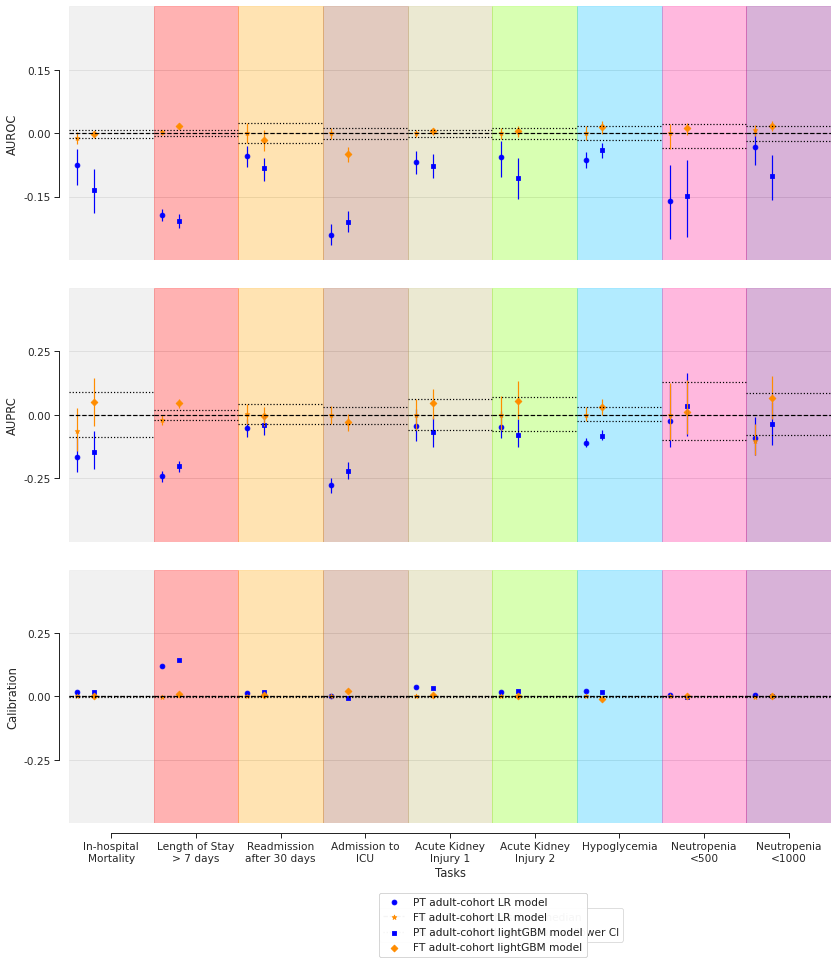

In [62]:
# For each task plot baseline vs CL
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12,15))
plt.tight_layout(w_pad=1,h_pad=0.5,rect=[0.05,0.15,1,0.95])

fg = 'shared'

for r, metric in enumerate(metrics):
    for c, task in enumerate(tasks):
        legend = []
        legend_text = []
        col_num = 0.6
        axes[r].axvspan(c+0.5, c+1.5,0,1,color=bg_colours[task], alpha=0.3)
        
        bl_lr_evals = bl_lr_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="pediatric"')
        
        # Pretrained adult-cohort logistic regression model
        pt_lr_evals = bl_lr_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="adult"')
        pt_lr_evals['CI_upper'] = (pt_lr_evals['CI_upper'] - pt_lr_evals['CI_med']).abs()
        pt_lr_evals['CI_lower'] = (pt_lr_evals['CI_med'] - pt_lr_evals['CI_lower']).abs()
        pt_lr_evals['CI_med'] = pt_lr_evals['CI_med'] - bl_lr_evals['CI_med']
        
        pt_lr_line = axes[r].scatter(
            c+0.6,
            pt_lr_evals['CI_med'],
            color = dot_colours['adult_pretrained'],
            marker = dot_shapes['PT-LR']
        )
        legend.append(pt_lr_line)
        legend_text.append('PT adult-cohort LR model')
        axes[r].errorbar(
            c+0.6,
            pt_lr_evals['CI_med'],
            pt_lr_evals[['CI_lower', 'CI_upper']].values.T,
            color = dot_colours['adult_pretrained']
        )
        
        # Finetuned adult-cohort logistic regression model
        ft_lr_evals = ft_lr_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="adult"')
        ft_lr_evals['CI_upper'] = (ft_lr_evals['CI_upper'] - ft_lr_evals['CI_med']).abs()
        ft_lr_evals['CI_lower'] = (ft_lr_evals['CI_med'] - ft_lr_evals['CI_lower']).abs()
        ft_lr_evals['CI_med'] = ft_lr_evals['CI_med'] - bl_lr_evals['CI_med']
        
        ft_lr_line = axes[r].scatter(
            c+0.6,
            ft_lr_evals['CI_med'],
            color = dot_colours['adult_finetuned'],
            marker = dot_shapes['FT-LR']
        )
        legend.append(ft_lr_line)
        legend_text.append('FT adult-cohort LR model')
        axes[r].errorbar(
            c+0.6,
            ft_lr_evals['CI_med'],
            ft_lr_evals[['CI_lower', 'CI_upper']].values.T,
            color = dot_colours['adult_finetuned']
        )
        
        # Pretrained adult-cohort GBM model
        pt_gbm_evals = pt_gbm_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="adult"')
        pt_gbm_evals['CI_upper'] = (pt_gbm_evals['CI_upper'] - pt_gbm_evals['CI_med']).abs()
        pt_gbm_evals['CI_lower'] = (pt_gbm_evals['CI_med'] - pt_gbm_evals['CI_lower']).abs()
        pt_gbm_evals['CI_med'] = pt_gbm_evals['CI_med'] - bl_lr_evals['CI_med']

        pt_gbm_line = axes[r].scatter(
            c+0.8,
            pt_gbm_evals['CI_med'],
            color = dot_colours['adult_pretrained'],
            marker = dot_shapes['PT-GBM']
        )
        legend.append(pt_gbm_line)
        legend_text.append('PT adult-cohort lightGBM model')
        axes[r].errorbar(
            c+0.8,
            pt_gbm_evals['CI_med'],
            pt_gbm_evals[['CI_lower', 'CI_upper']].values.T,
            color = dot_colours['adult_pretrained']
        )
        
        # Finetuned adult-cohort GBM model
        ft_gbm_evals = ft_gbm_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="adult"')
        ft_gbm_evals['CI_upper'] = (ft_gbm_evals['CI_upper'] - ft_gbm_evals['CI_med']).abs()
        ft_gbm_evals['CI_lower'] = (ft_gbm_evals['CI_med'] - ft_gbm_evals['CI_lower']).abs()
        ft_gbm_evals['CI_med'] = ft_gbm_evals['CI_med'] - bl_lr_evals['CI_med']

        ft_gbm_line = axes[r].scatter(
            c+0.8,
            ft_gbm_evals['CI_med'],
            color = dot_colours['adult_finetuned'],
            marker = dot_shapes['FT-GBM']
        )
        legend.append(ft_gbm_line)
        legend_text.append('FT adult-cohort lightGBM model')
        axes[r].errorbar(
            c+0.8,
            ft_gbm_evals['CI_med'],
            ft_gbm_evals[['CI_lower', 'CI_upper']].values.T,
            color = dot_colours['adult_finetuned']
        )
        
#         # Pretrained adult-cohort CLMBR model
#         pt_clmbr_evals = pt_clmbr_evals.query('task==@task and metric==@metric and cohort=="adult"')
#         pt_clmbr_evals['CI_upper'] = (pt_clmbr_evals['CI_upper'] - pt_clmbr_evals['CI_med']).abs()
#         pt_clmbr_evals['CI_lower'] = (pt_clmbr_evals['CI_med'] - pt_clmbr_evals['CI_lower']).abs()
#         pt_clmbr_evals['CI_med'] = pt_clmbr_evals['CI_med'] - bl_lr_evals['CI_med']

#         pt_clmbr_line = axes[r].scatter(
#             c+1.0,
#             pt_clmbr_evals['CI_med'],
#             color = dot_colours['adult'],
#             marker = dot_shapes['PT-CLMBR']
#         )
#         legend.append(pt_clmbr_line)
#         legend_text.append('PT adult-cohort CLMBR model')
#         axes[r].errorbar(
#             c+1.0,
#             pt_clmbr_evals['CI_med'],
#             pt_clmbr_evals[['CI_lower', 'CI_upper']].values.T,
#             color = dot_colours['adult']
#         )

#         # Finetuned adult-cohort CLMBR model
#         ft_clmbr_evals = ft_clmbr_evals.query('task==@task and metric==@metric and cohort=="adult"')
#         ft_clmbr_evals['CI_upper'] = (ft_clmbr_evals['CI_upper'] - ft_clmbr_evals['CI_med']).abs()
#         ft_clmbr_evals['CI_lower'] = (ft_clmbr_evals['CI_med'] - ft_clmbr_evals['CI_lower']).abs()
#         ft_clmbr_evals['CI_med'] = ft_clmbr_evals['CI_med'] - bl_lr_evals['CI_med']

#         ft_clmbr_line = axes[r].scatter(
#             c+1.0,
#             ft_clmbr_evals['CI_med'],
#             color = dot_colours['adult'],
#             marker = dot_shapes['FT-CLMBR']
#         )
#         legend.append(ft_clmbr_line)
#         legend_text.append('FT adult-cohort CLMBR model')
#         axes[r].errorbar(
#             c+1.0,
#             ft_clmbr_evals['CI_med'],
#             ft_clmbr_evals[['CI_lower', 'CI_upper']].values.T,
#             color = dot_colours['adult']
#         )

        bl_lr_evals['CI_upper'] = (bl_lr_evals['CI_upper'] - bl_lr_evals['CI_med']).abs()
        bl_lr_evals['CI_lower'] = (bl_lr_evals['CI_med'] - bl_lr_evals['CI_lower']).abs()
        bl_lr_evals['CI_med'] = bl_lr_evals['CI_med'] - bl_lr_evals['CI_med']

        bl_line = axes[r].plot([c+0.5, c+1.5],[bl_lr_evals['CI_med'], bl_lr_evals['CI_med']], linestyle='dashed', color='black')
        axes[r].plot([c+0.5, c+1.5],[bl_lr_evals['CI_upper'], bl_lr_evals['CI_upper']], linestyle='dotted', color='black')
        axes[r].plot([c+0.5, c+1.5],[-bl_lr_evals['CI_lower'], -bl_lr_evals['CI_lower']], linestyle='dotted', color='black')

        plt.xticks(np.arange(1,len(tasks)+1,1))
        axes[r].set_ylim(y_axis[metric]['lim'])
        axes[r].set_xlim([0.5,len(tasks)+0.5])
        axes[r].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r].grid(which='major', linewidth=0.5, axis='y')
        if r == 0:
            axes[r].set_title('')
        if r == len(metrics) - 1:
            axes[r].set_xlabel('Tasks')
            axes[r].set_xticklabels(labels=[titles[t] for t in tasks])
        else:
            axes[r].set_xticklabels('')
            axes[r].set_xlabel('')
            axes[r].spines['bottom'].set_color('white')
            axes[r].tick_params(axis='x', length=0)  
        axes[r].set_ylabel(y_axis[metric]['label'])
        axes[r].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


bl_leg = [Line2D([0],[0], linestyle='dashed', color='black'),
                Line2D([0],[0], linestyle='dotted', color='black')] 
bl_leg_lbls = ['LR ped. cohort baseline median', 'LR ped. cohort baseline upper/lower CI']
bl_legend = plt.legend(bl_leg, bl_leg_lbls, bbox_to_anchor=(0.4,-0.45,0.1,0.1), loc="center left")
plt.gca().add_artist(bl_legend)

cmp_legend = plt.legend(legend, legend_text, bbox_to_anchor=(0.4,-0.45,0.1,0.1), loc="center left")
plt.gca().add_artist(cmp_legend)


sns.despine(offset=10, trim=True,)


plt.savefig('figures/lr_comp_bl.png', bbox_inches='tight')
plt.show()
